In [1]:
!pip3 install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
!pip3 install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
import os
import torch
import torchvision as tv
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from PIL import Image

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class RoadModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
        
        self.train_metrics = []
        self.valid_metrics = []
        self.test_metrics = []
        self.epochs_passed = 0

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.optimizer = self.configure_optimizers()

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)        
        return mask

    def shared_step(self, batch, stage):
        image = batch[0].to(device)
        
        if stage == 'train':
            self.train()
        elif stage == 'valid' or stage == 'test':
            self.eval()

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1].to(device)

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        if stage == 'train':
            self.training_step_outputs.append({"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn})
        elif stage == 'valid':
            self.validation_step_outputs.append({"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn})
        elif stage == 'test':
            self.test_step_outputs.append({"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn})

        return loss

    def shared_epoch_end(self, stage):
        # aggregate step metics

        if stage == 'train':
            tp = torch.cat([x["tp"] for x in self.training_step_outputs])
            fp = torch.cat([x["fp"] for x in self.training_step_outputs])
            fn = torch.cat([x["fn"] for x in self.training_step_outputs])
            tn = torch.cat([x["tn"] for x in self.training_step_outputs])
        elif stage == 'valid':
            tp = torch.cat([x["tp"] for x in self.validation_step_outputs])
            fp = torch.cat([x["fp"] for x in self.validation_step_outputs])
            fn = torch.cat([x["fn"] for x in self.validation_step_outputs])
            tn = torch.cat([x["tn"] for x in self.validation_step_outputs])
        elif stage == 'test':
            tp = torch.cat([x["tp"] for x in self.test_step_outputs])
            fp = torch.cat([x["fp"] for x in self.test_step_outputs])
            fn = torch.cat([x["fn"] for x in self.test_step_outputs])
            tn = torch.cat([x["tn"] for x in self.test_step_outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
        if stage == 'train':
            self.train_metrics.append(dataset_iou.item())
        if stage == 'valid':
            self.valid_metrics.append(dataset_iou.item())
        if stage == 'test':
            self.test_metrics.append(dataset_iou.item())
            
        scheduler.step()

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def on_train_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)

In [5]:
class RoadsTrainset(Dataset):
    def __init__(self, transforms = tv.transforms.ToTensor()) -> None:
        super().__init__()

        self.image_path = '/usr/src/app/roads_dataset/png/train/'
        self.label_path = '/usr/src/app/roads_dataset/png/train_labels/'
        
        self.images = os.listdir(self.image_path)
        self.labels = os.listdir(self.label_path)

        for i in range(len(self.images)):
            self.images[i] = transforms(Image.open(self.image_path + self.images[i]))
            self.labels[i] = transforms(Image.open(self.label_path + self.labels[i]))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        #return super().__getitem__(index)
        return self.images[index], self.labels[index]

class RoadsValidset(Dataset):
    def __init__(self, transforms = tv.transforms.ToTensor()) -> None:
        super().__init__()

        self.image_path = '/usr/src/app/roads_dataset/png/val/'
        self.label_path = '/usr/src/app/roads_dataset/png/val_labels/'

        self.images = os.listdir(self.image_path)
        self.labels = os.listdir(self.label_path)

        for i in range(len(self.images)):
            self.images[i] = transforms(Image.open(self.image_path + self.images[i]))
            self.labels[i] = transforms(Image.open(self.label_path + self.labels[i]))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        #return super().__getitem__(index)
        return self.images[index], self.labels[index]
    
class RoadTestset(Dataset):
    def __init__(self, transforms = tv.transforms.ToTensor()) -> None:
        super().__init__()

        self.image_path = '/usr/src/app/roads_dataset/png/test/'
        self.label_path = '/usr/src/app/roads_dataset/png/test_labels/'

        self.images = os.listdir(self.image_path)
        self.labels = os.listdir(self.label_path)

        for i in range(len(self.images)):
            self.images[i] = transforms(Image.open(self.image_path + self.images[i]))
            self.labels[i] = transforms(Image.open(self.label_path + self.labels[i]))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        #return super().__getitem__(index)
        return self.images[index], self.labels[index]

In [6]:
def create_sets():
    if 'train_dataset' in os.listdir('./'):
        train_dataset = torch.load('train_dataset')
    else:
        train_dataset = RoadsTrainset(transforms=transforms)
        torch.save(train_dataset, 'train_dataset')

    if 'valid_dataset' in os.listdir('./'):
        valid_dataset = torch.load('valid_dataset')
    else:
        valid_dataset = RoadsValidset(transforms=transforms)
        torch.save(valid_dataset, 'valid_dataset')

    if 'test_set' in os.listdir('./'):
        test_dataset = torch.load('test_dataset')
    else:
        test_dataset = RoadTestset(transforms=transforms)
        torch.save(test_dataset, 'test_dataset')

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
    valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=10, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)

    return train_dataloader, valid_dataloader, test_dataloader

def steps():
    trainer.fit(
        model, 
        train_dataloaders=train_dataloader, 
        val_dataloaders=valid_dataloader
    )
    trainer.test(
        model,
        test_dataloader
    )

In [7]:
epochs = 500

transforms = tv.transforms.Compose([tv.transforms.ToTensor(),
                                    tv.transforms.Resize([1472, 1472])])

torch.autograd.set_detect_anomaly(True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

train_dataloader, valid_dataloader, test_dataloader = create_sets()
model = RoadModel("FPN", "resnet34", in_channels=3, out_classes=1)
model.to(device)

scheduler = torch.optim.lr_scheduler.OneCycleLR(model.optimizer, max_lr=0.001, steps_per_epoch=10, epochs=10)

trainer = pl.Trainer( 
    accelerator='gpu',
    devices=1,
    max_epochs=epochs,
)

steps()

cuda:0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 111/111 [02:14<00:00,  1.21s/it, v_num=91]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 111/111 [02:16<00:00,  1.23s/it, v_num=91, valid_per_image_iou=0.141, valid_dataset_iou=0.0687, train_per_image_iou=0.152, train_dataset_iou=0.127]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 111/111 [02:16<00:00,  1.23s/it, v_num=91, valid_per_image_iou=0.183, valid_dataset_iou=0.0796, train_per_image_iou=0.203, train_dataset_iou=0.178]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 111/111 [02:16<00:00,  1.23s/it, v_num=91, valid_per_image_iou=0.223, valid_dataset_iou=0.0944, train_per_image_iou=0.235, train_dataset_iou=0.213]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 111/111 [02:16<00:00,  1.23s/it, v_num=91, valid_per_image_iou=0.248, valid_dataset_iou=0.115, train_per_image_iou=0.257, train_dataset_iou=0.239]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 111/111 [02:16<00:00,  1.23s/it, v_num=91, valid_per_im

ValueError: Tried to step 102 times. The specified number of total steps is 100

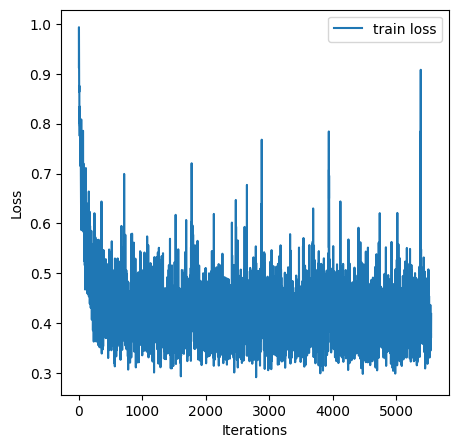

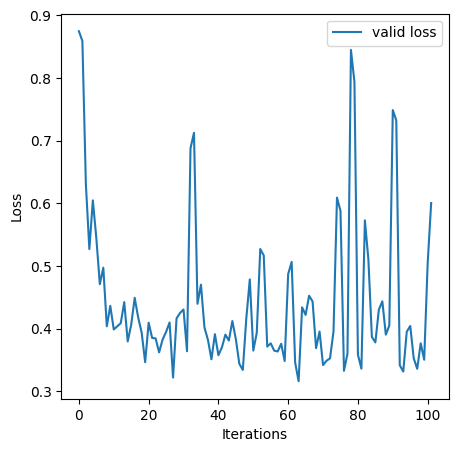

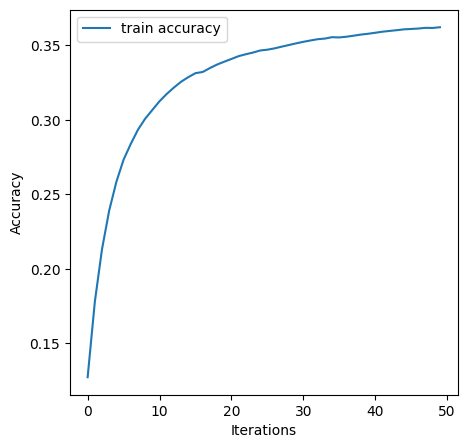

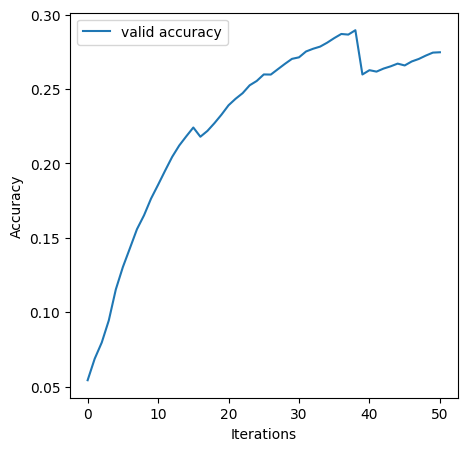

[]


In [8]:
train_loss = [i['loss'].item() for i in model.training_step_outputs]
valid_loss = [i['loss'].item() for i in model.validation_step_outputs]
train_metrics = model.train_metrics
valid_metrics = model.valid_metrics
test_metrics = model.test_metrics

fig = plt.figure(figsize=(5, 5))
plt.plot(train_loss, label='train loss')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.plot(valid_loss, label='valid loss')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.plot(train_metrics, label='train accuracy')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.plot(valid_metrics, label='valid accuracy')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

print(test_metrics)

In [9]:
print('min train loss: ', min(train_loss))
print('min valid loss: ', min(valid_loss))

min train loss:  0.29109954833984375
min valid loss:  0.31624484062194824


In [ ]:
img = (train_dataloader.dataset[0][0] - model.mean) / model.std
mask = train_dataloader.dataset[0][1]
out = model.model(img)
        
img = img.cpu().numpy()[0]
mask = mask.numpy()
out = out.detach().cpu().numpy()[0]
        
plt.imshow(img.transpose(1, 2, 0))
plt.show()
plt.imshow(mask.transpose(1, 2, 0))
plt.show()
plt.imshow(out.transpose(1, 2, 0))
plt.show()